In [1]:
import pandas as pd
import numpy as np

# Procesamiento columna 'Descripción'

In [24]:
excel_file = pd.ExcelFile('../data/raw/data_20220117.xlsx')
sheets = excel_file.sheet_names
sheets

['Lista de equipos',
 'Historico calif 2_1(10 años)',
 'Historico calif 1_9 (10 años)',
 'T-PAP(C)_T-ACE',
 'Hoja3',
 'ARC(I)_ARC(D)',
 'DP',
 'OIL.TAP',
 'DIEL.PF_ DIEL',
 'OIL.CORR',
 'PRO-M',
 'M.OLTC',
 'ENF',
 'CUB',
 'HUM']

In [25]:
import unidecode

def norm_descrpcion(s):
    s = s.lower()
    s = unidecode.unidecode(s)
    return s

converter_descripcion = {}
converter_descripcion['Descripción'] = norm_descrpcion

df_collection = {}
for name in sheets:
    df_collection[name] = pd.read_excel('../data/raw/data_20220117.xlsx', sheet_name=name, converters=converter_descripcion)

## Separación manual

In [28]:
def separacion_manual(dframe, originales, reemplazos, adiciones):
    df = dframe.copy()
    for i in range(len(originales)):
        index = df['Descripción'] == originales[i]
        if sum(index) > 0:
            instancias = df.loc[index].copy()
            df.loc[index,'Descripción'] = reemplazos[i]
            df = df.append(instancias, ignore_index = True)
            df.loc[len(df) - sum(index):,'Descripción'] = adiciones[i]
    return df




df_collection_separados = {}

excel_file_reemplazos = pd.ExcelFile('../data/reemplazos_manual/reemplazos_manual2.xlsx')
sheets_reemplazos = excel_file_reemplazos.sheet_names
df_collection_manuales = {}

converter_manuales = {}
converter_manuales['Originales'] = norm_descrpcion
converter_manuales['Reemplazos'] = norm_descrpcion
converter_manuales['Adiciones'] = norm_descrpcion

for name in sheets_reemplazos:#sheets_reemplazos:
    df_collection_manuales[name] = pd.read_excel('../data/reemplazos_manual/reemplazos_manual2.xlsx', sheet_name = name, converters = converter_manuales)
    index_manuales = ~df_collection_manuales[name].loc[:,'Reemplazos'].isna()
    originales = df_collection_manuales[name].loc[index_manuales, 'Originales'].values
    reemplazos = df_collection_manuales[name].loc[index_manuales, 'Reemplazos'].values
    adiciones = df_collection_manuales[name].loc[index_manuales, 'Adiciones'].values
    df_collection_separados[name] = separacion_manual(df_collection[name], originales, reemplazos, adiciones)

## Normalización por palabras claves

In [30]:
palabras_clave = {}
palabras_clave['revisar/cambiar motoventilador'] = ['motoventilador','ventilador','motoventiladores','ventiladores']
palabras_clave['realizar analisis dga y humedad seguimiento'] = ['dga']
palabras_clave['hacer seguimiento generacion anormal de gases'] = ['generacion','energizacion','gases']
palabras_clave['cambiar silica oltc'] = ['silica']
palabras_clave['cambiar filtro oltc'] = ['filtro']
palabras_clave['realizar secado oltc'] = ['secado']
palabras_clave['realizar muestreo-analisis fsco-qco oltc'] = ['aceite','muestra','fsco','qco']
palabras_clave['realizar regeneramiento aceite aislante'] = ['regeneramiento','regeneracion']
palabras_clave['adicionar irgamet39 a 100ppm'] = ['irgamet','pasivador','pasivar']
palabras_clave['temperatura devenado'] = ['calibrar indicador temperatura devanados']
palabras_clave['efectuar prueba de descargas parciales'] = ['descargas parc']
palabras_clave['seguimiento durante montaje'] = ['durante montaje']
palabras_clave['verificar condicion antes energizar oltc'] = ['energizar']
palabras_clave['realizar prueba estimacion humedad whrt'] = ['estimacion humedad']
palabras_clave['cambiar valvula alivio presion'] = ['alivio presion', 'alivio de presion','valvula alivio','valvula de alivio','valvula de sobre presion','valvula sobre presion','valvula de sobrepresion','valvula sobrepresion']
palabras_clave['presion subita'] = ['cambiar rele presion subita']
palabras_clave['revisar/cambiar contador cambiador tapsbiador'] = ['contador']
df_collection_pc = df_collection_separados.copy()
unicos_pc = {}
index_unicos_pc = {}

for name in sheets_reemplazos:
    unicos = pd.unique(df_collection_separados[name]['Descripción'])
    index_unicos = np.zeros(len(unicos))
    for i in range(len(unicos)):
        index_unicos[i] = i
        for key,value in palabras_clave.items():
            for word in value:
                if word in unicos[i]:
                    df_collection_pc[name] = df_collection_pc[name].replace(unicos[i],key)
                    unicos[i] = key
                    break
    unicos_pc[name] = unicos
    index_unicos_pc[name] = index_unicos

## Aplicando el algoritmo de distancia de Levenshtein

### Algoritmo de Levenshtein

In [31]:
def dist_lev(s1,s2):
    dist_matrix = np.zeros((len(s1) + 1, len(s2) + 1))
    dist_matrix[1:,0] = range(1,len(s1) + 1)
    dist_matrix[0,1:] = range(1,len(s2) + 1)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            if s1[i - 1] == s2[j - 1]:
                dist_matrix[i,j] = min(dist_matrix[i - 1, j] + 1, 
                                    dist_matrix[i - 1, j - 1], 
                                    dist_matrix[i, j - 1] + 1)
            else:
                dist_matrix[i,j] = min(dist_matrix[i - 1, j] + 1, 
                                    dist_matrix[i - 1, j - 1] + 1, 
                                    dist_matrix[i, j - 1] + 1)
    return dist_matrix[-1,-1]

### Aplicando y ordenando según distancia

In [32]:
# Extrayendo valores únicos:
ordenados_collection = {}
dist_ordenados_collection = {}
index_ordenados_collection = {}
for name in sheets_reemplazos:
    unicos = pd.unique(unicos_pc[name])
    #Construyendo matriz de distancia de Levenshtein
    dist_unicos = np.zeros((len(unicos), len(unicos)))
    for i in range(len(unicos)):
        for j in range(i + 1, len(unicos)):
            dist_unicos[i, j] = dist_lev(unicos[i], unicos[j])
            dist_unicos[j,i] = dist_unicos[i,j] 
    #Inizializar varibales
    # dist_unicos = np.array([[0,8,8,10.5],[1,0,4,3],[2,5,0,6],[8,10,7,0]])
    # unicos = [1,2,3,4]
    ordenados = ['']*len(unicos)
    dist_ordenados = np.zeros(len(unicos))
    index_ordenados = np.zeros(len(unicos))
    #Ubicando primer elemento
    max_dist_index = np.argmax(dist_unicos)
    max_dist_index = np.unravel_index(max_dist_index, np.shape(dist_unicos))
    row = max_dist_index[0]
    ordenados[0] = unicos[row]
    index_ordenados[0] = row
    dist_ordenados[0] = 0
    dist_unicos[row,:] = np.inf
    #Diagonal igual a infinito
    for i in range(len(unicos)):
        dist_unicos[i,i] = np.inf
    #Ubicando el resto de los elementos
    for i in range(len(unicos) - 1):
        min_dist = np.min(dist_unicos[:,row])
        dist_ordenados[i + 1] = dist_ordenados[i] + min_dist
        row = np.argmin(dist_unicos[:,row])
        ordenados[i + 1] = unicos[row]
        index_ordenados[i + 1] = row
        dist_unicos[row,:] = np.inf
    #Ubicándolos por hoja
    ordenados_collection[name] = ordenados
    dist_ordenados_collection[name] = dist_ordenados
    index_ordenados_collection[name] = index_ordenados


### Escribiendo los resultados en Excel

In [33]:
import xlsxwriter
workbook = xlsxwriter.Workbook('../data/reemplazos_manual/unicos_ordenados_20220117.xlsx')
for name in sheets_reemplazos:
    worksheet = workbook.add_worksheet(name)
    for i in range(len(ordenados_collection[name])): 
        worksheet.write(i,0,ordenados_collection[name][i])
        worksheet.write(i,1,ordenados_collection[name][i])
        worksheet.write(i,2,dist_ordenados_collection[name][i])
        worksheet.write(i,3,index_ordenados_collection[name][i])

workbook.close()

# Separación por equipos

In [34]:
equipos_unicos = pd.unique(df_collection['Lista de equipos']['Equipo'])
df_collection_equipos = {}
for sheet in sheets_reemplazos:
    df_collection_equipos[sheet] = pd.DataFrame()
    equipos_unicos = pd.unique(df_collection_pc[sheet]['Equipo'])
    for equipo in equipos_unicos:
        df_equipo = df_collection_pc[sheet].loc[df_collection_pc[sheet]['Equipo'] == equipo].copy()
        descripciones_unicas = pd.unique(df_equipo['Descripción'])
        equipo_descripcion = {'Equipo':[equipo]*len(descripciones_unicas),'Descripción':descripciones_unicas}
        df_collection_equipos[sheet] = df_collection_equipos[sheet].append(pd.DataFrame(equipo_descripcion),ignore_index = True)


In [35]:
df_collection_equipos['T-PAP(C)_T-ACE']

,Equipo,Descripción
0,809578,realizar analisis dga y humedad seguimiento
1,809578,revisar/cambiar motoventilador
2,809578,efectuar seguimiento anomalia termica
3,809578,realizar muestreo-analisis fsco-qco oltc
4,810449,realizar analisis dga y humedad seguimiento
...,...,...
91,203342,cambiar indicador de nivel cuba ppal
92,203342,realizar analisis dga y humedad seguimiento
93,118423,revisar/cambiar motoventilador
94,118423,montaje de moto ventiladir


# Lectura de la calificación más reciente

In [36]:
import datetime
from datetime import datetime
from datetime import timedelta


datetime_format = '%Y-%m-%d %H:%M:%S'
df_collection_diferencias = {}

#Calificaciones históricas
df_calificaciones_historico = df_collection['Historico calif 2_1(10 años)']
date_format = '%Y-%m-%d %H:%M:%S'
for i in range(len(sheets_reemplazos)):
    sheet = sheets_reemplazos[i]
    df_collection_diferencias[sheet] = pd.DataFrame()
    for j in range(len(df_collection_pc[sheet])):
        #Extraer equipo, acción y fecha de cada acción de mantenimiento
        equipo = df_collection_pc[sheet].loc[j,'Equipo']
        accion = df_collection_pc[sheet].loc[j,'Descripción']
        fecha_accion = df_collection_pc[sheet].loc[j,'Creado el']
        fecha_accion_datetime = datetime.strptime(str(fecha_accion),datetime_format)

        #Encontrar la fecha de calificación más cercana
        index_equipo = (df_calificaciones_historico['Equipo'] == equipo).tolist()
        index_anterior = (df_calificaciones_historico['Creado el'] < fecha_accion).tolist()
        index_calificacion = np.logical_or(['/' in str(texto) for texto in df_calificaciones_historico['Texto'].tolist()], \
            ['/' in str(texto_ampliado) for texto_ampliado in df_calificaciones_historico['Texto Ampliado'].tolist()]) 
        index_total = np.logical_and(index_equipo,index_anterior)
        index_total = np.logical_and(index_total,index_calificacion)  

        if any(index_total):
            fechas_calificacion = df_calificaciones_historico.loc[index_total,'Creado el']
            min_delta = timedelta(days = 100000)
            for index_fc, fc in fechas_calificacion.items():
                fecha_calificacion_datetime = datetime.strptime(str(fc),datetime_format)
                delta = fecha_accion_datetime - fecha_calificacion_datetime
                if delta < min_delta:
                    min_delta = delta
                    min_index = index_fc
                    min_texto = df_calificaciones_historico.loc[min_index,'Texto Ampliado']
                    if pd.isnull(min_texto):
                        min_texto = df_calificaciones_historico.loc[min_index,'Texto']
        else:
            min_delta = timedelta(days = -1)
            min_index = -1
            min_texto = None
        instancia = {'Equipo':equipo,'Descripción':accion,'Mínima diferencia':min_delta.days,'Index calificación':min_index,'Texto':min_texto}
        df_collection_diferencias[sheet] = df_collection_diferencias[sheet].append(pd.DataFrame(instancia,index =[j]),ignore_index = True)
    print(sheet)
    positive_index = pd.isnull(df_collection_diferencias[sheet]['Texto']).tolist()
    positive_index = np.logical_not(positive_index)
    print(str(sum(positive_index)) + '/' + str(j + 1))
    print('Percentage: ' + str(100*sum(positive_index)/(j + 1)) + '%')
    print('Mean: ' + str(df_collection_diferencias[sheet]['Mínima diferencia'].loc[positive_index].mean()))

T-PAP(C)_T-ACE
58/160
Percentage: 36.25%
Mean: 256.58620689655174
ARC(I)_ARC(D)
27/47
Percentage: 57.4468085106383%
Mean: 84.37037037037037
DP
7/27
Percentage: 25.925925925925927%
Mean: 259.2857142857143
OIL.TAP
109/362
Percentage: 30.11049723756906%
Mean: 133.77981651376146
DIEL.PF_ DIEL
19/42
Percentage: 45.23809523809524%
Mean: 103.63157894736842
OIL.CORR
36/75
Percentage: 48.0%
Mean: 89.55555555555556
PRO-M
205/546
Percentage: 37.54578754578755%
Mean: 283.05853658536586
M.OLTC
26/112
Percentage: 23.214285714285715%
Mean: 89.34615384615384
ENF
81/225
Percentage: 36.0%
Mean: 214.23456790123456
CUB
24/87
Percentage: 27.586206896551722%
Mean: 157.33333333333334
HUM
34/81
Percentage: 41.97530864197531%
Mean: 180.5


# Dataset todas las calificaciones

In [39]:
#Dataframe de diferencias trazables
import re

df_diferencias_trazables = pd.DataFrame()

for sheet in sheets_reemplazos:
    positive_index = pd.isnull(df_collection_diferencias[sheet]['Texto']).tolist()
    positive_index = np.logical_not(positive_index)
    df_diferencias_trazables = df_diferencias_trazables.append(df_collection_diferencias[sheet].loc[positive_index],ignore_index = True)

rutinas = {} #Key: Rutina principal, Value: Rutinas secundarias
rutinas['DGA'] = ['T.ACE','T.PAP','DP','ARC']
rutinas['OIL.TAP'] = []
rutinas['ADIT.OIL'] = ['DBPC','BTZ']
rutinas['OIL.CORR'] = []
rutinas['OIL'] = ['DIE','FQ']
rutinas['BUJ'] = []
rutinas['INSP'] = ['ENF','PRO.M','M.OLTC','CUB','GAB','BUJ.TER']
rutinas['HUM.PAP'] = ['DELTA','T.M','T.TRF','FECHA','DIAG','WHRT']
rutinas['HUM'] = ['DELTA','T.M','T.TRF','FECHA','DIAG']
rutinas['FUR'] = ['2FAL','TOT','RAT','REL','MAX']
rutinas['PF.DEV'] = ['GND','BARR','PRESB']
rutinas['SFRA'] = ['RAD','AXI','BULK','CORE','IMP','CONT','SELF','IMG','NO.DIAG']




columnas = ['Equipo','Descripción']
for principal,secundarias in rutinas.items():
    columnas.append(principal)
    for s in secundarias:
        columnas.append(principal + '-' + s)

df_calificaciones = pd.DataFrame(columns = columnas, index = df_diferencias_trazables.index)

for index in range(len(df_diferencias_trazables.index)):
    row = df_diferencias_trazables.loc[index]
    df_calificaciones.loc[index,'Equipo'] = row['Equipo']
    df_calificaciones.loc[index,'Descripción'] = row['Descripción']
    texto = row['Texto']
    texto = texto.replace(' ','')
    texto = texto.replace('_','.')
    texto = texto.replace('-','.')
    if ':' in texto:
        texto = texto[texto.rindex(':') + 1:]
        primer_numerico = re.search("[0-9]",texto)
        texto = texto[primer_numerico.start():]   
    texto_principales = texto.split('/ /')
    for tp in texto_principales:
        #Buscar códigos de las rutinas principales en el texto
        for rutina_principal in rutinas.keys():
            index_inicio_principal = re.search(rutina_principal,tp)
            if not index_inicio_principal == None:
                #Extraer calificación rutina principal
                index_inicio_principal = index_inicio_principal.start()
                index_fin_principal = index_inicio_principal + len(rutina_principal)
                calificacion_principal = tp[index_inicio_principal - 2]
                df_calificaciones.loc[index,rutina_principal] = int(calificacion_principal)
                #Extraer calificaciones secundarias
                if index_fin_principal + 1 < len(tp):
                    texto_secundarias = tp[index_fin_principal + 1:]
                    texto_secundarias = texto_secundarias.split('/')
                    for ts in texto_secundarias:
                        #Buscar códigos de las rutinas secundarias
                        for rutina_secundaria in rutinas[rutina_principal]:
                            if not re.search(rutina_secundaria,ts) == None:
                                calificacion_secundaria = ts[0]
                                if not calificacion_secundaria.isnumeric(): #Si no tiene calificación secundaria, se hereda la calificación principal
                                    calificacion_secundaria = calificacion_principal
                                df_calificaciones.loc[index,rutina_principal + '-' + rutina_secundaria] = int(calificacion_secundaria)
                #continue


## Análisis DataSet (todas las rutinas)

In [40]:
df_calificaciones

,Equipo,Descripción,DGA,DGA-T.ACE,DGA-T.PAP,DGA-DP,DGA-ARC,OIL.TAP,ADIT.OIL,ADIT.OIL-DBPC,...,SFRA,SFRA-RAD,SFRA-AXI,SFRA-BULK,SFRA-CORE,SFRA-IMP,SFRA-CONT,SFRA-SELF,SFRA-IMG,SFRA-NO.DIAG
0,810451,revisar/cambiar motoventilador,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,810451,realizar muestreo y analisis furanos,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,810451,revisar/cambiar motoventilador,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,202718,revision indicadores temperatura/t pozos,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,202719,revision indicadores temperatura/t pozos,2,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,115058,realizar anali. cont.humedad+rigidez die,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
622,109355,corregir ingreso humedad termometro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
623,117273,cambiar silica oltc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,115057,realizar muestreo-analisis fsco-qco oltc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_calificaciones['Descripción'].value_counts()

realizar muestreo-analisis fsco-qco oltc    142
revisar/cambiar motoventilador              106
cambiar silica oltc                          61
aplicar sikaflex 1a protecciones mecanic     44
realizar secado oltc                         23
                                           ... 
realizar evaluacion condicion aceit oltc      1
realizar termovacio (eqcues)                  1
revisar funcionamiento rele de sello          1
cambiar protec mecanicas                      1
corregir alarm respirador oltc fase c         1
Name: Descripción, Length: 143, dtype: int64

In [42]:
n_calificaciones_fila = pd.Series('float64')
for index, row in df_calificaciones.iterrows():
    n_calificaciones_fila[index] = len(df_calificaciones.columns) - row.isnull().sum() - 2


Mean of califications per row: 5.0303514376996805


1       1
2      74
3      46
4     154
5     134
6      76
7      74
8      40
9      10
10      9
12      5
13      2
16      1
dtype: int64

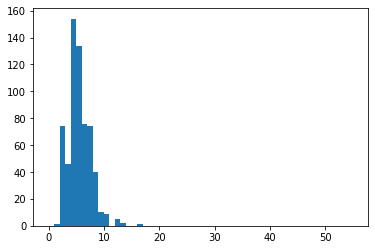

In [43]:
import matplotlib.pyplot as plt
row_hist = plt.hist(n_calificaciones_fila,bins = range(len(df_calificaciones.columns)))
print('Mean of califications per row: ' + str(n_calificaciones_fila.mean()))
n_calificaciones_fila.value_counts(sort = False)

# Modelos

## Preprocesamiento

### Conservando los primeras 4 categorías y llenando por "otros"

In [45]:
n_calificaciones = 6
calificaciones_frecuentes = df_calificaciones['Descripción'].value_counts().index[:n_calificaciones].tolist()
print("Calificaciones más frecuentes: ")
print(calificaciones_frecuentes)
df_calificaciones_frecuentes = df_calificaciones.copy()
for index, row in df_calificaciones_frecuentes.iterrows():
    if not row['Descripción'] in calificaciones_frecuentes:
        df_calificaciones_frecuentes.loc[index,'Descripción'] = 'otro'
df_calificaciones_frecuentes
print('Frecuencias resultantes: ')
print(df_calificaciones_frecuentes['Descripción'].value_counts())

Calificaciones más frecuentes: 
['realizar muestreo-analisis fsco-qco oltc', 'revisar/cambiar motoventilador', 'cambiar silica oltc', 'aplicar sikaflex 1a protecciones mecanic', 'realizar secado oltc', 'hacer seguimiento generacion anormal de gases']
Frecuencias resultantes: 
otro                                             229
realizar muestreo-analisis fsco-qco oltc         142
revisar/cambiar motoventilador                   106
cambiar silica oltc                               61
aplicar sikaflex 1a protecciones mecanic          44
realizar secado oltc                              23
hacer seguimiento generacion anormal de gases     21
Name: Descripción, dtype: int64


### Extracción variable de salida
 


In [49]:
import csv

In [54]:
df_calificaciones_frecuentes.to_csv("out.csv",sep="|",encoding="latin-1")



In [46]:
acciones_mantenimiento = df_calificaciones_frecuentes['Descripción']
df_calificaciones_frecuentes_numerico = df_calificaciones_frecuentes.drop('Descripción',1)
#Reemplazando NaN por 0
df_calificaciones_frecuentes_numerico = df_calificaciones_frecuentes_numerico.fillna(0)
df_calificaciones_frecuentes_numerico.astype(str).astype(int)

,Equipo,DGA,DGA-T.ACE,DGA-T.PAP,DGA-DP,DGA-ARC,OIL.TAP,ADIT.OIL,ADIT.OIL-DBPC,ADIT.OIL-BTZ,...,SFRA,SFRA-RAD,SFRA-AXI,SFRA-BULK,SFRA-CORE,SFRA-IMP,SFRA-CONT,SFRA-SELF,SFRA-IMG,SFRA-NO.DIAG
0,810451,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,810451,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,810451,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,202718,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,202719,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,115058,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,109355,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
623,117273,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
624,115057,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Análisis de variables

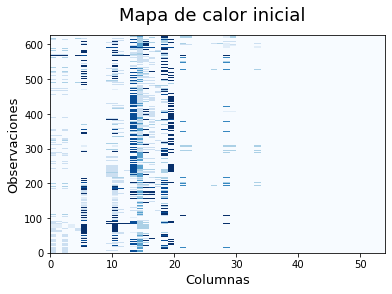

In [55]:
#Mapa de calor inicial
title_font_size = 18
axis_font_size = 13
primer_colormap = plt.figure()
plt.pcolormesh(df_calificaciones_frecuentes_numerico.iloc[:,1:],cmap = 'Blues')
primer_colormap.suptitle('Mapa de calor inicial', fontsize = title_font_size)
plt.xlabel('Columnas', fontsize = axis_font_size)
plt.ylabel('Observaciones', fontsize = axis_font_size)
plt.show()

### Eliminando columnas vacías

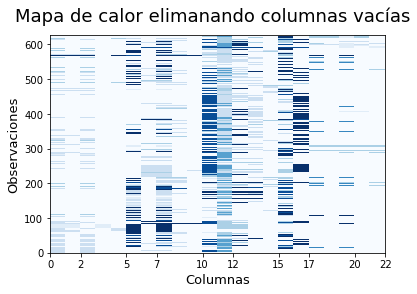

In [56]:
frecuencia_calificaciones = [np.count_nonzero(df_calificaciones_frecuentes_numerico[column]) for column in df_calificaciones_frecuentes_numerico.columns[1:]]
frecuencia_calificaciones_series = pd.Series(frecuencia_calificaciones, index = df_calificaciones_frecuentes_numerico.columns[1:])
frecuencia_calificaciones_series.sort_values()

columnas_vacias = frecuencia_calificaciones_series[frecuencia_calificaciones_series <= 5].index
df_calificaciones_llenas = df_calificaciones_frecuentes_numerico.copy()
df_calificaciones_llenas = df_calificaciones_llenas.drop(columnas_vacias,axis = 1)

#Colormap
colormap_llenas = plt.figure()
plt.pcolormesh(df_calificaciones_llenas.iloc[:,1:],cmap = 'Blues')
colormap_llenas.suptitle('Mapa de calor elimanando columnas vacías', fontsize = title_font_size)
plt.xlabel('Columnas', fontsize = axis_font_size)
plt.ylabel('Observaciones', fontsize = axis_font_size)
locs, labels = plt.xticks()
plt.xticks([int(loc) for loc in locs])
plt.show()

## Muestreo estratificado

In [69]:
from sklearn.model_selection import StratifiedShuffleSplit
n_modelos = 1
sss = StratifiedShuffleSplit(n_splits = n_modelos, test_size = 0.2, random_state = 0)
train_index = []
test_index = []

for split, model_index in zip(sss.split(df_calificaciones_llenas,acciones_mantenimiento),range(n_modelos)):
    train_index.insert(model_index,split[0])
    test_index.insert(model_index,split[1])

## Random Forest

In [75]:
type( pd.DataFrame(y_pred_train_rf))

pandas.core.frame.DataFrame

In [80]:
pd.concat([acciones_mantenimiento,pd.DataFrame(y_pred_train_rf),df_calificaciones_llenas], axis=1).to_csv("reales_vs_predichos2.csv",sep="|",encoding="latin-1")


In [78]:
df_calificaciones_llenas

,Equipo,DGA,DGA-T.ACE,DGA-T.PAP,DGA-DP,DGA-ARC,OIL.TAP,OIL.CORR,OIL,OIL-DIE,...,INSP-ENF,INSP-PRO.M,INSP-M.OLTC,INSP-CUB,INSP-GAB,HUM.PAP,HUM.PAP-DELTA,HUM,HUM-DELTA,HUM-DIAG
0,810451,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,810451,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,810451,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,202718,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,202719,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,2,2,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,115058,0,0,0,0,0,0,0,0,0,...,0,3,0,9,0,3,3,1,3,0
622,109355,0,0,0,0,0,0,0,0,0,...,3,3,0,3,9,0,0,1,1,0
623,117273,0,0,0,0,0,0,0,0,0,...,9,2,0,0,9,0,0,0,0,0
624,115057,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,3,3,1,3,0


In [70]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score

rnd_forest = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 0)
sample_cont = 1
nombres_metricas = ['Accuracy','Precision','Recall','F1']
acc_train_rf = np.zeros(n_modelos)
prec_train_rf = np.zeros(n_modelos)
rec_train_rf = np.zeros(n_modelos)
f1_train_rf = np.zeros(n_modelos)


average_metric = 'weighted'
for train in train_index:
    rnd_forest.fit(df_calificaciones_llenas.loc[train], acciones_mantenimiento[train])
    y_pred_train_rf = rnd_forest.predict(df_calificaciones_llenas.loc[train])

    n_correct = sum(y_pred_train_rf == acciones_mantenimiento[train])
    acc = n_correct/len(y_pred_train_rf)
    prec = precision_score(acciones_mantenimiento[train],y_pred_train_rf, average = average_metric)
    rec = recall_score(acciones_mantenimiento[train],y_pred_train_rf, average = average_metric)
    f1 = f1_score(acciones_mantenimiento[train],y_pred_train_rf, average = average_metric)

    acc_train_rf[sample_cont - 1] = acc
    prec_train_rf[sample_cont - 1] = prec
    rec_train_rf[sample_cont - 1] = rec
    f1_train_rf[sample_cont - 1] = f1

    print('Muestra #' + str(sample_cont) + ':')
    print('Accuracy (Conjunto de entrenamiento): ' + str(acc))
    print('Precision (Conjunto de entrenamiento): ' + str(prec))
    print('Recall (Conjunto de entrenamiento): ' + str(rec))
    print('F1 (Conjunto de entrenamiento): ' + str(f1))
    sample_cont = sample_cont + 1



    
    




Muestra #1:
Accuracy (Conjunto de entrenamiento): 0.804
Precision (Conjunto de entrenamiento): 0.8042223390392587
Recall (Conjunto de entrenamiento): 0.804
F1 (Conjunto de entrenamiento): 0.8033424565335443


In [59]:
for metrica, array in zip(nombres_metricas, [acc_train_rf,prec_train_rf,rec_train_rf,f1_train_rf]):
    print('Métrica: ' + metrica)
    print('Media: '+ str(array.mean()))
    print('Dev. Std: ' + str(array.std()))


Métrica: Accuracy
Media: 0.8042
Dev. Std: 0.008576712656956613
Métrica: Precision
Media: 0.8052994427085232
Dev. Std: 0.00833444681318788
Métrica: Recall
Media: 0.8042
Dev. Std: 0.008576712656956613
Métrica: F1
Media: 0.8019208681745518
Dev. Std: 0.008496740275980552


## Regresión

In [60]:
reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
sample_cont = 1
nombres_metricas = ['Accuracy','Precision','Recall','F1']
acc_train_reg = np.zeros(n_modelos)
prec_train_reg = np.zeros(n_modelos)
rec_train_reg = np.zeros(n_modelos)
f1_train_reg = np.zeros(n_modelos)

average_metric = 'weighted'
for train in train_index:
    reg.fit(df_calificaciones_llenas.loc[train], acciones_mantenimiento[train])
    y_pred_train_reg = reg.predict(df_calificaciones_llenas.loc[train])

    n_correct = sum(y_pred_train_reg == acciones_mantenimiento[train])
    acc = n_correct/len(y_pred_train_reg)
    prec = precision_score(acciones_mantenimiento[train],y_pred_train_reg, average = average_metric)
    rec = recall_score(acciones_mantenimiento[train],y_pred_train_reg, average = average_metric)
    f1 = f1_score(acciones_mantenimiento[train],y_pred_train_reg, average = average_metric)

    acc_train_reg[sample_cont - 1] = acc
    prec_train_reg[sample_cont - 1] = prec
    rec_train_reg[sample_cont - 1] = rec
    f1_train_reg[sample_cont - 1] = f1

    print('Muestra #' + str(sample_cont) + ':')
    print('Accuracy (Conjunto de entrenamiento): ' + str(acc))
    print('Precision (Conjunto de entrenamiento): ' + str(prec))
    print('Recall (Conjunto de entrenamiento): ' + str(rec))
    print('F1 (Conjunto de entrenamiento): ' + str(f1))
    sample_cont = sample_cont + 1

C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being

Muestra #1:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #2:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #3:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #4:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #5:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #6

C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being

Muestra #8:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #9:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #10:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #11:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #12:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra

C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being

Muestra #15:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #16:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #17:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #18:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muestra #19:
Accuracy (Conjunto de entrenamiento): 0.366
Precision (Conjunto de entrenamiento): 0.133956
Recall (Conjunto de entrenamiento): 0.366
F1 (Conjunto de entrenamiento): 0.19612884333821376
Muest

In [61]:
for metrica, array in zip(nombres_metricas, [acc_train_reg,prec_train_reg,rec_train_reg,f1_train_reg]):
    print('Métrica: ' + metrica)
    print('Media: '+ str(array.mean()))
    print('Dev. Std: ' + str(array.std()))

Métrica: Accuracy
Media: 0.36599999999999994
Dev. Std: 5.551115123125783e-17
Métrica: Precision
Media: 0.133956
Dev. Std: 0.0
Métrica: Recall
Media: 0.36599999999999994
Dev. Std: 5.551115123125783e-17
Métrica: F1
Media: 0.19612884333821376
Dev. Std: 0.0


## Voting

In [62]:
vot_rf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 0)
vot_reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
vot_clf = VotingClassifier(estimators = [('lr',vot_reg),('rf',vot_rf)],voting = 'soft')
sample_cont = 1
nombres_metricas = ['Accuracy','Precision','Recall','F1']
acc_train_vot = np.zeros(n_modelos)
prec_train_vot = np.zeros(n_modelos)
rec_train_vot = np.zeros(n_modelos)
f1_train_vot = np.zeros(n_modelos)

average_metric = 'weighted'
for train in train_index:
    vot_clf.fit(df_calificaciones_llenas.loc[train], acciones_mantenimiento[train])
    y_pred_train_vot = vot_clf.predict(df_calificaciones_llenas.loc[train])

    n_correct = sum(y_pred_train_vot == acciones_mantenimiento[train])
    acc = n_correct/len(y_pred_train_vot)
    prec = precision_score(acciones_mantenimiento[train],y_pred_train_vot, average = average_metric)
    rec = recall_score(acciones_mantenimiento[train],y_pred_train_vot, average = average_metric)
    f1 = f1_score(acciones_mantenimiento[train],y_pred_train_vot, average = average_metric)

    acc_train_vot[sample_cont - 1] = acc
    prec_train_vot[sample_cont - 1] = prec
    rec_train_vot[sample_cont - 1] = rec
    f1_train_vot[sample_cont - 1] = f1

    print('Muestra #' + str(sample_cont) + ':')
    print('Accuracy (Conjunto de entrenamiento): ' + str(acc))
    print('Precision (Conjunto de entrenamiento): ' + str(prec))
    print('Recall (Conjunto de entrenamiento): ' + str(rec))
    print('F1 (Conjunto de entrenamiento): ' + str(f1))
    sample_cont = sample_cont + 1


Muestra #1:
Accuracy (Conjunto de entrenamiento): 0.802
Precision (Conjunto de entrenamiento): 0.8039186662182489
Recall (Conjunto de entrenamiento): 0.802
F1 (Conjunto de entrenamiento): 0.7990577521845625
Muestra #2:
Accuracy (Conjunto de entrenamiento): 0.802
Precision (Conjunto de entrenamiento): 0.8135476036643414
Recall (Conjunto de entrenamiento): 0.802
F1 (Conjunto de entrenamiento): 0.7965461084123532
Muestra #3:
Accuracy (Conjunto de entrenamiento): 0.794
Precision (Conjunto de entrenamiento): 0.8004370662799443
Recall (Conjunto de entrenamiento): 0.794
F1 (Conjunto de entrenamiento): 0.7889687501084238
Muestra #4:
Accuracy (Conjunto de entrenamiento): 0.788
Precision (Conjunto de entrenamiento): 0.790100429033674
Recall (Conjunto de entrenamiento): 0.788
F1 (Conjunto de entrenamiento): 0.7819168708985612
Muestra #5:
Accuracy (Conjunto de entrenamiento): 0.808
Precision (Conjunto de entrenamiento): 0.8132095452273863
Recall (Conjunto de entrenamiento): 0.808
F1 (Conjunto de e

In [63]:
for metrica, array in zip(nombres_metricas, [acc_train_vot,prec_train_vot,rec_train_vot,f1_train_vot]):
    print('Métrica: ' + metrica)
    print('Media: '+ str(array.mean()))
    print('Dev. Std: ' + str(array.std()))

Métrica: Accuracy
Media: 0.7999
Dev. Std: 0.009283856957105712
Métrica: Precision
Media: 0.806977702281553
Dev. Std: 0.009800200734144116
Métrica: Recall
Media: 0.7999
Dev. Std: 0.009283856957105712
Métrica: F1
Media: 0.7938321905535963
Dev. Std: 0.010063263985872697


## Testeo

In [64]:
from sklearn.metrics import accuracy_score
fun_metricas = [accuracy_score,precision_score,recall_score,f1_score]
nombres_metricas = ['Accuaracy','Precision','Recall','F1']
clasificadores_finales = [rnd_forest,vot_clf]
acc_test = np.zeros((n_modelos,len(clasificadores_finales)))
prec_test = np.zeros((n_modelos,len(clasificadores_finales)))
rec_test = np.zeros((n_modelos,len(clasificadores_finales)))
f1_test = np.zeros((n_modelos,len(clasificadores_finales)))
sample_cont = 1
average_metric = 'weighted'

for test in test_index:
    print('Muestra #' + str(sample_cont))
    for metrica,nombre,metrica_array in zip(fun_metricas,nombres_metricas,[acc_test,prec_test,rec_test,f1_test]):
        print(nombre + ': ')
        for clf,clf_number in zip(clasificadores_finales,range(len(clasificadores_finales))):
            y_pred = clf.predict(df_calificaciones_llenas.loc[test])
            try:
                metrica_array[sample_cont - 1,clf_number] = metrica(acciones_mantenimiento[test],y_pred,average = average_metric)
            except:
                metrica_array[sample_cont - 1,clf_number] = metrica(acciones_mantenimiento[test],y_pred)
            print(clf.__class__.__name__, metrica_array[sample_cont - 1,clf_number])
    sample_cont = sample_cont + 1

            

Muestra #1
Accuaracy: 
RandomForestClassifier 0.7301587301587301
VotingClassifier 0.7380952380952381
Precision: 
RandomForestClassifier 0.7465885867288392
VotingClassifier 0.761680963069852
Recall: 
RandomForestClassifier 0.7301587301587301
VotingClassifier 0.7380952380952381
F1: 
RandomForestClassifier 0.7248607787427662
VotingClassifier 0.7265523739735384
Muestra #2
Accuaracy: 
RandomForestClassifier 0.7063492063492064
VotingClassifier 0.7063492063492064
Precision: 
RandomForestClassifier 0.6958559518083328
VotingClassifier 0.7025920015326795
Recall: 
RandomForestClassifier 0.7063492063492064
VotingClassifier 0.7063492063492064
F1: 
RandomForestClassifier 0.690336162414025
VotingClassifier 0.6898076705562667
Muestra #3
Accuaracy: 
RandomForestClassifier 0.7619047619047619
VotingClassifier 0.7698412698412699
Precision: 
RandomForestClassifier 0.7649116105772451
VotingClassifier 0.7731576057544279
Recall: 
RandomForestClassifier 0.7619047619047619
VotingClassifier 0.7698412698412699
F1

## Resultados

### Entrenamiento

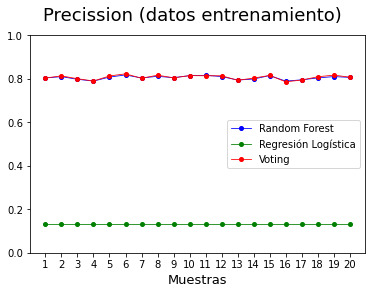

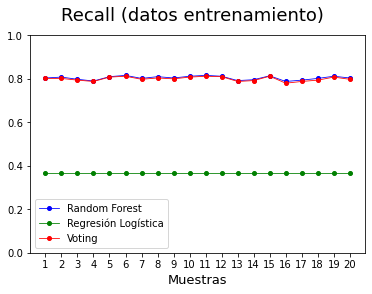

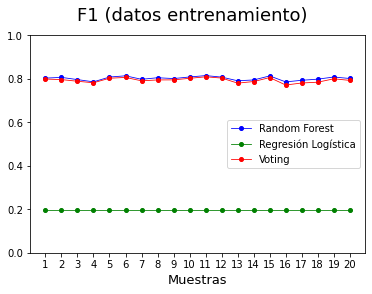

In [65]:
#Resultados de entrenamiento
from matplotlib.pyplot import plot
figure_number = 1
for metric,nombre_metrica in zip(['prec','rec','f1'],['Precission','Recall','F1']):
    for model,model_name,color in zip(['rf','reg','vot'],['Random Forest','Regresión Logística','Voting'],['b','g','r']):    
        figure = plt.figure(figure_number)
        plt.plot(range(1,n_modelos + 1),
            vars()[metric + '_train_' + model],
            color = color,linestyle= '-',marker = 'o',label = model_name,linewidth = 0.8, markersize = 4)
        locs, labels = plt.xticks()
        plt.xticks([int(loc) for loc in range(1,n_modelos + 1)])
        plt.suptitle(nombre_metrica + ' (datos entrenamiento)', fontsize = title_font_size)
        plt.xlabel('Muestras', fontsize = axis_font_size)
        plt.ylim((0,1))      
        plt.legend()
        plt.show
    figure_number = figure_number + 1



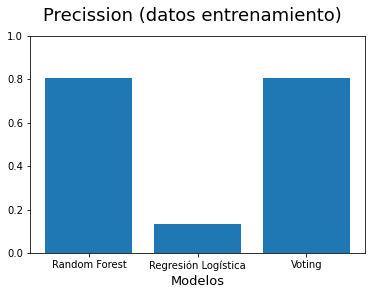

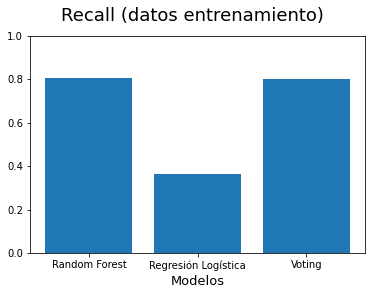

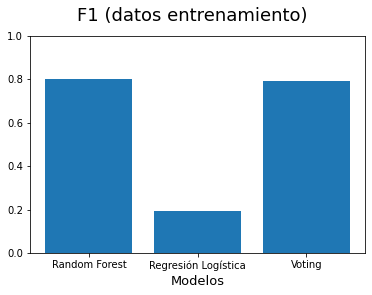

In [66]:
figure_number = 1
nombres_metricas = ['Precission','Recall','F1']
nombres_modelos = ['Random Forest','Regresión Logística','Voting']
for metric,nombre_metrica in zip(['prec','rec','f1'],nombres_metricas):
    y = np.zeros(len(nombres_modelos))
    for model,model_name,model_number in zip(['rf','reg','vot'],nombres_modelos,range(len(nombres_modelos))):    
        figure = plt.figure(figure_number)
        y[model_number] = vars()[metric + '_train_' + model].mean()


    plt.bar(range(1,len(nombres_modelos) + 1),y)
    plt.xticks(ticks = range(1,len(nombres_modelos) + 1), labels = nombres_modelos)
    plt.suptitle(nombre_metrica + ' (datos entrenamiento)', fontsize = title_font_size)
    plt.xlabel('Modelos', fontsize = axis_font_size)
    plt.ylim((0,1))      
    plt.show()
    figure_number = figure_number + 1

### Testeo

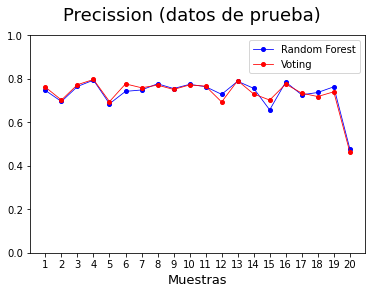

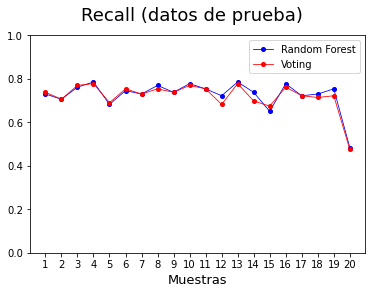

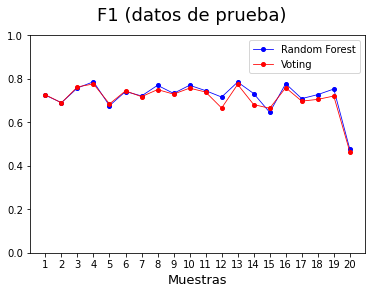

In [67]:
figure_number = 1
for metric,nombre_metrica in zip(['prec','rec','f1'],['Precission','Recall','F1']):
    for model,model_name,color,model_number in zip(['rf','vot'],['Random Forest','Voting'],['b','r'],range(len(clasificadores_finales))):    
        figure = plt.figure(figure_number)
        plt.plot(range(1,n_modelos + 1),
            vars()[metric + '_test'][:,model_number],
            color = color,linestyle= '-',marker = 'o',label = model_name,linewidth = 0.8, markersize = 4)
        locs, labels = plt.xticks()
        plt.xticks([int(loc) for loc in range(1,n_modelos + 1)])
        plt.suptitle(nombre_metrica + ' (datos de prueba)', fontsize = title_font_size)
        plt.xlabel('Muestras', fontsize = axis_font_size)
        plt.ylim((0,1))      
        plt.legend()
        plt.show
    figure_number = figure_number + 1

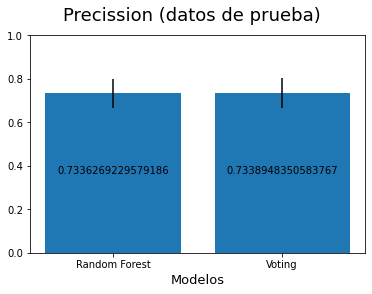

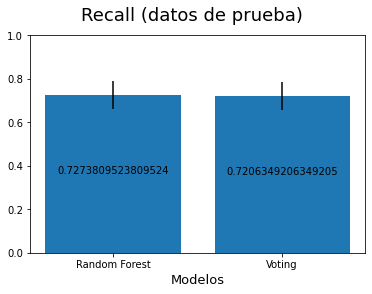

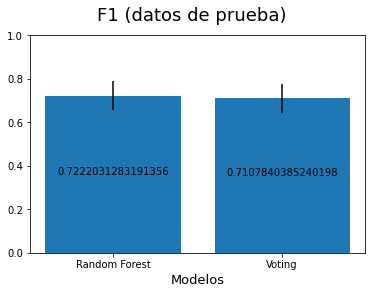

In [68]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i + 1, y[i]/2, y[i], ha = 'center')

figure_number = 1
nombres_metricas = ['Precission','Recall','F1']
nombres_modelos = ['Random Forest','Voting']
for metric,nombre_metrica in zip(['prec','rec','f1'],nombres_metricas):
    y = np.zeros(len(nombres_modelos))
    yerr = np.zeros(len(nombres_modelos))
    for model,model_name,model_number in zip(['rf','vot'],nombres_modelos,range(len(clasificadores_finales))):    
        figure = plt.figure(figure_number)
        y[model_number] = vars()[metric + '_test'][:,model_number].mean()
        yerr[model_number] = vars()[metric + '_test'][:,model_number].std()
    
    plt.bar(range(1,len(clasificadores_finales) + 1),y,yerr = yerr)
    plt.xticks(ticks = range(1,len(nombres_modelos) + 1), labels = nombres_modelos)

    addlabels(nombres_modelos, y)
    plt.suptitle(nombre_metrica + ' (datos de prueba)', fontsize = title_font_size)
    plt.xlabel('Modelos', fontsize = axis_font_size)
    plt.ylim((0,1))      
    plt.show()
    figure_number = figure_number + 1
